In [ ]:
## mount gdrive
import os
from google.colab import drive
drive.mount('/content/drive/')
# Check if a GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive/
Device: cuda


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from skimage.transform import radon
import torchvision
import os
import pickle
import random
import numpy as np
import gzip
import torchvision.datasets as datasets
from torchvision import transforms
transform = torchvision.transforms.Compose([transforms.ToTensor()])

#### some data-loading functionalities
datapath = '/content/drive/My Drive/assistant_prof_jobs_documents/IIT-Kgp ECE job/teaching@IITKgp/cambridge_IA_minor_2025/coursework_codes/practical_codes/mnist_dataset'
full_trainset = datasets.MNIST(root=datapath, train=True, download=False, transform=transform)
full_testset = datasets.MNIST(root=datapath, train=False, download=False, transform=transform)
print('total #train images: {}, #test images: {}'.format(len(full_trainset), len(full_testset)))

#### we will create a small subset of MNIST for both training and testing
random_sampler_train = torch.utils.data.RandomSampler(full_trainset, num_samples=2000)
train_dataloader = torch.utils.data.DataLoader(full_trainset, batch_size=20, sampler=random_sampler_train)

random_sampler_test = torch.utils.data.RandomSampler(full_testset, num_samples=100)
test_dataloader = torch.utils.data.DataLoader(full_testset, batch_size=20, sampler=random_sampler_test)

total #train images: 60000, #test images: 10000


In [ ]:
### returns the forward operator and the adjoint given a kernel of size p-by-p
def conv2d_block(kernel, channels, p, device, stride=1):
    """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
        kernel: 2D kernel, p x p is the kernel size
        channels: number of image channels
    """
    kernel_size = kernel.shape
    kernel = kernel/kernel.sum()
    kernel = kernel.repeat(channels, 1, 1, 1)
    filter = nn.Conv2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2
    )
    filter.weight.data = kernel
    filter.weight.requires_grad = False

    filter_adjoint = nn.ConvTranspose2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2,
    )
    filter_adjoint.weight.data = kernel
    filter_adjoint.weight.requires_grad = False

    return filter.to(device), filter_adjoint.to(device)

# Motion blur operator
p = 7 #kernel_size
kernel_motion_blur = (1/p**2)*torch.ones((p, p)).type(torch.FloatTensor).to(device)
fwd_op, adj_op = conv2d_block(kernel_motion_blur, channels = 1, p = 7, device=device)

In [ ]:
### create the networks
class prox_net_dual(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_dual, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class prox_net_primal(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_primal, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=5, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()

        self.fwd_op = fwd_op
        self.adj_op = adj_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(self.niter).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.cnn_image_layers = nn.ModuleList([prox_net_primal().to(device) for i in range(self.niter)])
        self.cnn_data_layers = nn.ModuleList([prox_net_dual().to(device) for i in range(self.niter)])

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for iteration in range(self.niter):
            h = self.cnn_data_layers[iteration](h, y, self.sigma[iteration] * self.fwd_op(x))
            x = self.cnn_image_layers[iteration](x, self.tau[iteration] * self.adj_op(h))
        return x


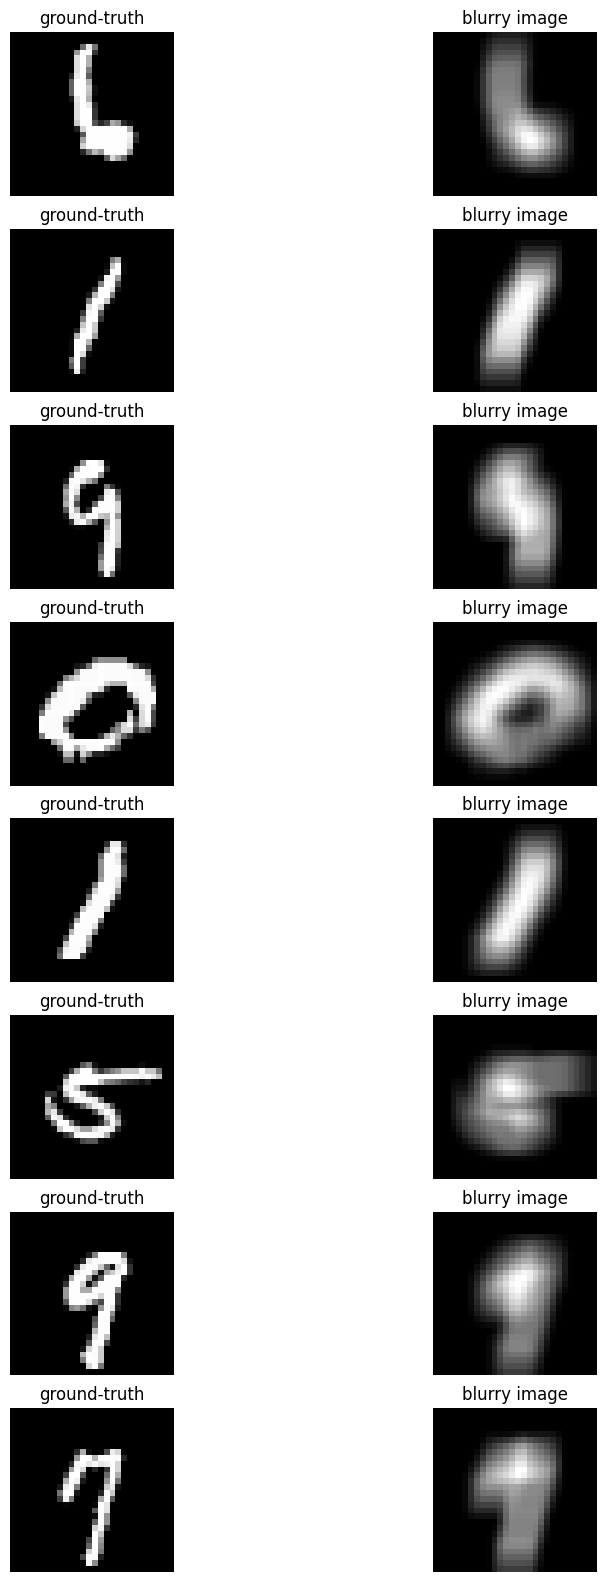

In [ ]:
#### Let's visualize some of the training images
for batch_idx, (x_true, _) in enumerate(train_dataloader):
  x_true = x_true.to(device)
  y = fwd_op(x_true)

  num_samples = min(8, y.size(0))  # Limit to 8 samples for visualization
  fig, axes = plt.subplots(num_samples, 2, figsize=(10, 20))
  ### let's see the images
  for i in range(num_samples):


        # Plot sinogram
        axes[i, 0].imshow((x_true[i].cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('ground-truth')

        # Plot ground truth image
        axes[i, 1].imshow((y[i].cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry image')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

  plt.show()
  break

In [ ]:
##### main training loop
lpd_net = LPD(fwd_op, adj_op, niter=5, sigma=1e-3, tau=1e-3).to(device)
print('# params in LPD-net = {}'.format(sum(p.numel() for p in lpd_net.parameters())))

loss_vs_train_steps = []

# define the loss and the optimizer
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lpd_net.parameters(), lr = 1e-3)
num_epochs = 40

### train the LPD network
for epoch in range(num_epochs):
  for batch_idx, (x_true, _) in enumerate(train_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init)
    loss = mse_loss(x_recon, x_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_vs_train_steps.append(loss.item())
    if(batch_idx % 2 == 0):
      print('batch:{}, epoch:{}, loss = {}'.format(batch_idx, epoch, loss.item()))



# params in LPD-net = 284778
batch:0, epoch:0, loss = 0.1344699114561081
batch:2, epoch:0, loss = 0.08678249269723892
batch:4, epoch:0, loss = 0.09024778008460999
batch:6, epoch:0, loss = 0.08946975320577621
batch:8, epoch:0, loss = 0.07987967878580093
batch:10, epoch:0, loss = 0.07994166761636734
batch:12, epoch:0, loss = 0.07281765341758728
batch:14, epoch:0, loss = 0.10756681114435196
batch:16, epoch:0, loss = 0.079773910343647
batch:18, epoch:0, loss = 0.0808538943529129
batch:20, epoch:0, loss = 0.09291479736566544
batch:22, epoch:0, loss = 0.07944067567586899
batch:24, epoch:0, loss = 0.07978782802820206
batch:26, epoch:0, loss = 0.07461052387952805
batch:28, epoch:0, loss = 0.061008695513010025
batch:30, epoch:0, loss = 0.05524815618991852
batch:32, epoch:0, loss = 0.05413496494293213
batch:34, epoch:0, loss = 0.05189956724643707
batch:36, epoch:0, loss = 0.05792917311191559
batch:38, epoch:0, loss = 0.05436934158205986
batch:40, epoch:0, loss = 0.04798658564686775
batch:42, epo

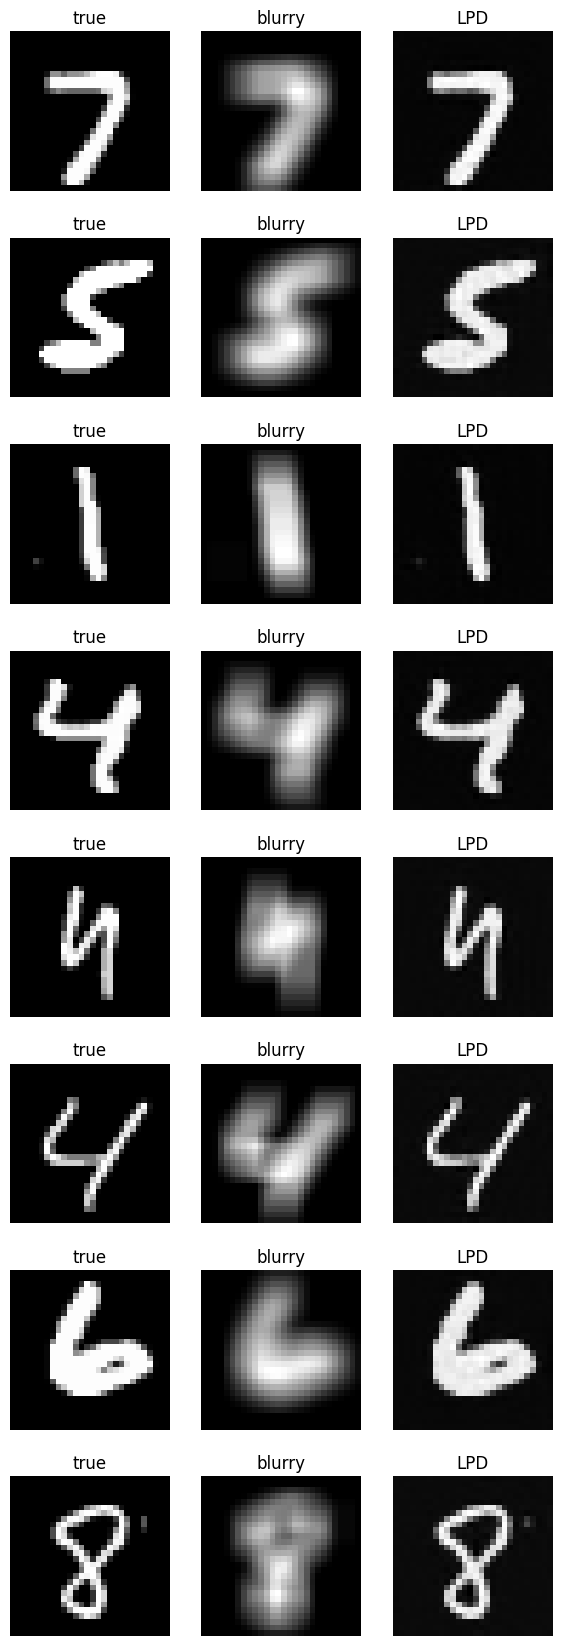

In [ ]:
### see how it performs on test images
for batch_idx, (x_true, _) in enumerate(test_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init) # reconstruct using the trained network

    num_samples = 8  # Limit to a few samples for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(7, 21))
    ### let's see the images
    for i in range(num_samples):
        # Plot true
        axes[i, 0].imshow((x_true[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('true')

        # Plot blurry
        axes[i, 1].imshow((y[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry')

        # Plot ground truth image
        axes[i, 2].imshow((x_recon[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 2].set_title('LPD')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')

    plt.show()
    break